In [1]:
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn import (LeakyReLU, MSELoss, Sequential, Module, Sigmoid)
from torch.optim import Adam
import math

In [2]:
# Custom dataloader
class NSEDataset(Dataset):
    
    '''Defines class for custom dataset in Pytorch.
    
            Parameters:
                root_dir (str) : location of data
                annotation_file (csv) : names of data for search and select
                transform : normalize(), etc.'''
    
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file, header=None)
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        matrix_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        # matrix = np.array(loadmat(matrix_path)[omega_sub])
        matrix = np.array(pd.read_csv(matrix_path, header=None))
        matrix = self.transform(matrix)
        # matrix_visual(matrix, '2d')  # visualize input data
        return torch.tensor(matrix, dtype=torch.double)

# Normalization transform
def normalize(matrix):
    '''Returns normalized matrix.
    
            Libraries:
                Numpy
            
            Parameters:
                matrix (array) : original matrix
            
            Outputs:
                marix (array) : normalized matrix.'''
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm
    return matrix

def matrix_visual(matrix, projection):
    '''Plots 2D or 3D data using matplotlib
    
            Libraries:
                matplotlib.pyplot
            
            Parameters:
                matrix (array) : data to be plotted
                projection (str) : plot in 2D or 3D
                
            Outputs:
                plot (plt) : visualization of data
    '''
    x = np.linspace(0, 255, 256)
    y = np.linspace(0, 255, 256)
    xx, yy = np.meshgrid(x, y)
    
    if projection == '2d':
        plt.contourf(xx, yy, matrix, cmap=cm.coolwarm)
    elif projection == '3d':
        ax = plt.axes(projection='3d')
        ax.plot_surface(xx, yy, matrix, cmap=cm.coolwarm)
    plt.show(block=False)
    plt.pause(0.2)
    plt.close('all')
    
# Average norm of batched data
def calculate_avg_norm(batched_data):
    '''Calculate the average norm of matrices of batched data.
       Calculates how sparse the data is and can be added to loss function to achieve sparsity.
        
        Libraries:
            numpy
            
        Parameters:
            batched_data (tensor) : pytorch tensor containing batches of matrices 
            
        Outputs:
            avg_norm (float) : average froebinius norm of all matrices in batched data
    '''
    total_norm = 0
    norms = 0
    for num, batch in enumerate(batched_data):
        for layer_num, layer in enumerate(batch):
            norm = np.linalg.norm(layer)
            total_norm += norm
            norms += 1
    avg_norm = total_norm / norms
    
    return avg_norm

def expand_tensor(tensor):
    '''Expand the channels of input tensor by factor of two. Create space to store fourier components.
    
        Libraries:
            torch
            
        Parameters:
            tensor (tensor) : tensor to be expanded, size = [batch_size, channels, height, width]
            
        Outputs:
            expanded_tensor (tensor)
    '''
    
    batch_size, channels, height, width = tensor.shape
    expanded_tensor = torch.zeros((batch_size, channels*2, height, width))
    
    for batch_index, batch in enumerate(expanded_tensor):
        for channel_index, channel in enumerate(batch):
            expanded_tensor[batch_index][channel_index] = tensor[batch_index][math.floor(channel_index/2)]
            
    return expanded_tensor

In [3]:
# Hyperparameters
batch_size = 1
epochs = 10
lr = 0.001

In [4]:
# Import data
training_data = NSEDataset(root_dir='/Users/darinmomayezi/Documents/Research/GrigorievLab/Autoencoder/Data/kolm_train/',
                    annotation_file='/Users/darinmomayezi/Documents/Research/GrigorievLab/Autoencoder/Data/kolm_train/kolm_names.csv',
                    transform=normalize)
eval_data = NSEDataset(root_dir='/Users/darinmomayezi/Documents/Research/GrigorievLab/Autoencoder/Data/kolm_test/',
            annotation_file='/Users/darinmomayezi/Documents/Research/GrigorievLab/Autoencoder/Data/kolm_test/kolm_names_test.csv',
            transform=normalize)

forcing = torch.tensor(np.array(pd.read_csv('/Users/darinmomayezi/Documents/Research/GrigorievLab/Autoencoder/Data/kolm/forcing/kolm1.csv', 
                                header=None)), dtype=torch.double)
forcing_batch = torch.unsqueeze(forcing, 0)
forcing = torch.unsqueeze(forcing, 0)

# A batch of forcing in one tensor
for i in range(batch_size-1):
    forcing_batch = torch.cat((forcing_batch, forcing), dim=0)

# Dataloaders
training_loader = DataLoader(training_data, batch_size=batch_size)
eval_loader = DataLoader(eval_data, batch_size=batch_size)
forcing_batch = torch.unsqueeze(forcing_batch, 1)  # batchd forcing data

In [5]:
# Shift matrix down w/ pbc

def shift_down(tensor, shift):
    batch_size, features, height, width = tensor.shape
    new_tensor = torch.zeros((batch_size, features, height, width))
    for batch_index, batch in enumerate(tensor):
        for feature_index, feature in enumerate(batch):
            for row_index, row in enumerate(feature):
                if row_index >= (height-1)-shift:
                    new_tensor[batch_index][feature_index][(height-1)-row_index] = row
                else:
                    new_tensor[batch_index][feature_index][row_index+shift] = row
            
    return new_tensor
        

In [6]:
# Fourier transform module

class FourierTransform(Module):
    
    def __init__(self):
        super(FourierTransform, self).__init__()
    
    def forward(self, input):
        fft = torch.fft.fft2(input)  # shape = [batch_size, channels, height, width]
        return fft
    
class InverseFourierTransform(Module):
    
    def __init__(self):
        super(InverseFourierTransform, self).__init__()
        self.bias = nn.Parameter(torch.tensor(0.001, requires_grad=True))
    
    def forward(self, input):
        ifft = torch.fft.ifft2(input)
        ifft = torch.view_as_real(ifft)[:, :, :, :, 0]
        # norm = np.linalg.norm(ifft.clone().detach().numpy())
        # ifft = ifft / norm + self.bias
        return ifft + self.bias
    
class CustomConvolution(Module):
    def __init__(self, in_features, out_features):
        super(CustomConvolution, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        
        self.kernel1 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features, 256, 256))
        self.kernel2 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features, 256, 256))
        self.kernel3 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features,  256, 256))
        self.kernel4 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features, 256, 256))
        self.kernel5 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features, 256, 256))
        self.kernel6 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features,  256, 256))
        self.kernel7 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features,  256, 256))
        self.kernel8 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features, 256, 256))
        self.kernel9 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features, 256, 256))
        self.kernel10 = nn.Parameter(torch.ones(batch_size, self.in_features, self.out_features,  256, 256))
        
        # self.weight1 = nn.Parameter(torch.ones(1, requires_grad=True))
        # self.weight2 = nn.Parameter(torch.ones(1, requires_grad=True))
        # self.weight3 = nn.Parameter(torch.ones(1, requires_grad=True))
        # self.weight4 = nn.Parameter(torch.ones(1, requires_grad=True))
        # self.weight5 = nn.Parameter(torch.ones(1, requires_grad=True))
        # self.weight6 = nn.Parameter(torch.ones(1, requires_grad=True))
        # self.bias1 = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        # self.bias2 = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        # self.bias3 = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        # self.bias4 = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        # self.bias5 = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        # self.bias6 = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        
    def forward(self, input):
        batch_size, in_features, height, width = input.shape
        result = torch.zeros((batch_size, self.out_features, height, width), dtype=torch.double)
        for batch_index, batch in enumerate(input):  # x shape = [batch_size, in_features, 256, 256]
            for out_node in range(self.out_features):
                feature_map = torch.zeros((height, width), dtype=torch.double)
                for in_node in range(in_features):
                    
                    kernel = self.kernel1[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel2[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel3[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel4[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel5[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel6[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel7[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel8[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel9[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                    
                    kernel = self.kernel10[batch_index][in_node][out_node]
                    convolution = torch.mul(kernel, batch[in_node])
                    feature_map = torch.add(feature_map, convolution, alpha=1)
                
                result[batch_index][out_node] = feature_map
                
        return result
            

class Model(Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.encode = Sequential(
            FourierTransform(),
            CustomConvolution(1, 10),
            InverseFourierTransform(),
            LeakyReLU()
        )
        
        self.decode = Sequential(
            FourierTransform(),
            CustomConvolution(10, 1),
            InverseFourierTransform(),
            LeakyReLU()
        )
        
    def forward(self, input):
        encoded = self.encode(input)
        decoded = self.decode(encoded)
        return (encoded, decoded)
    

INPUT


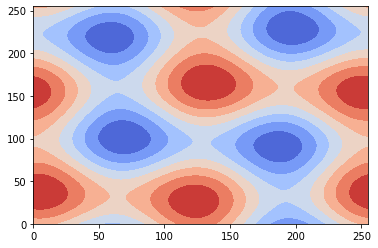

RESULT


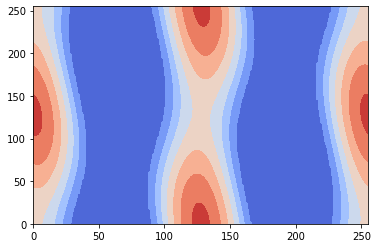

SHIFTED


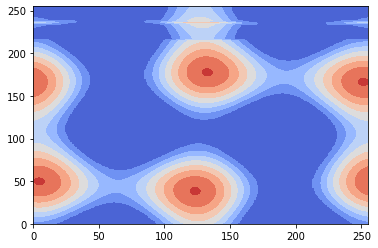

INPUT


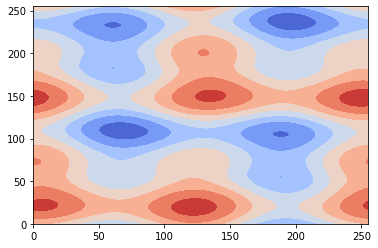

RESULT


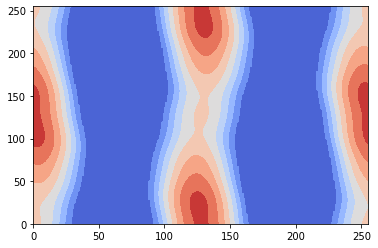

SHIFTED


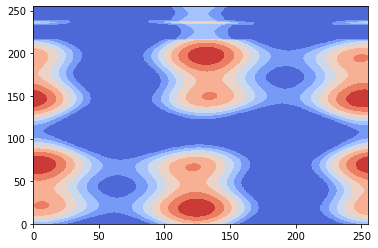

INPUT


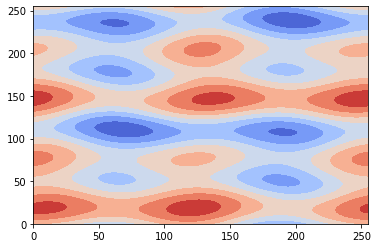

RESULT


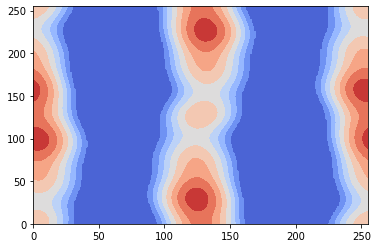

SHIFTED


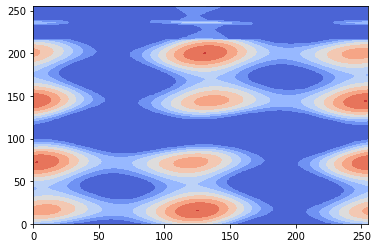

INPUT


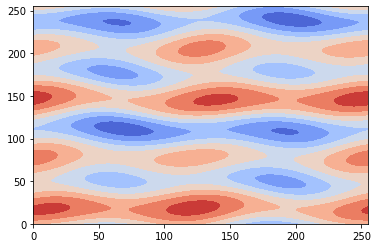

RESULT


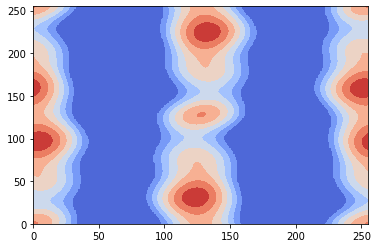

SHIFTED


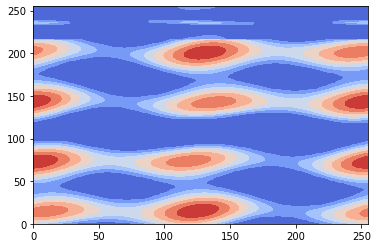

INPUT


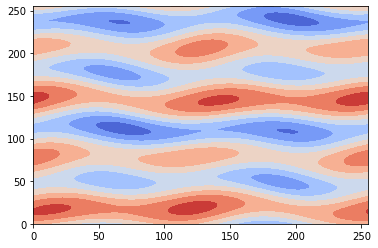

RESULT


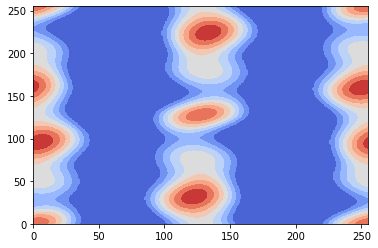

SHIFTED


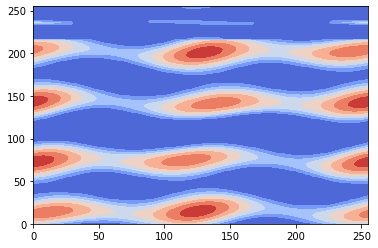

INPUT


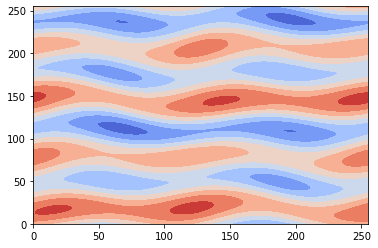

RESULT


KeyboardInterrupt: 

In [31]:
model = Model()
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
# for name, param in model.named_parameters():
#     if name != 'encode.2.bias' and name != 'decode.2.bias' and name == 'decode.1.rows':
#         print(name, param[0][0])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1) 

for epoch in range(epochs):
    running_loss = 0
    previous = {}
    shifted_previous = {}
    for index, input in enumerate(training_loader):
        # for name, param in model.named_parameters():
        #     if name == 'decode.1.rows':
        #         print(name, param[0][0][0][0])
        model.train()
        optimizer.zero_grad()
        input = torch.unsqueeze(input, 1)
        input.requires_grad = True
        future = 0
        height, width = input.shape[2:]
        
        shifted = shift_down(input, 20)
        if index < future:
            previous[index] = input
            shifted_previous[index] = shifted
        else:
            # shifting
            # translated = shift_down(input, 100)
            # result_translated = model(translated)
            # # print('ORIGINAL')
            # # matrix_visual(result[-1][0][0].clone().detach().numpy(), '2d')
            # print('BEFORE')
            # matrix_visual(input[-1][0].clone().detach().numpy(), '2d')
            # print('TRANSLATED')
            # matrix_visual(translated[-1][0].clone().detach().numpy(), '2d')
            

            # matrix_visual(result_translated[-1][0][0].clone().detach().numpy(), '2d')
            delta = 0
            previous[index] = input
            result = model(previous[index-future])
            
            shifted_previous[index] = shifted
            shifted_result = model(shifted_previous[index-future])
            shifted_previous[index - future] = 0
            # with torch.no_grad():
            #     avg_norm = calculate_avg_norm(result[-1])
        
            # loss = ((input - result[-1]).mean())**2
            loss = criterion(input, result[-1])
            # recon_loss = loss - delta*avg_norm
            # running_loss += recon_loss.item()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(loss)
            previous[index-future] = 0
            
            
            
        
        # Sparsity : minimize matrix norm
        # delta = 0
        # with torch.no_grad():
        #     avg_norm = calculate_avg_norm(result[-1])
    
        # loss = ((input - result[-1]).mean())**2 + delta*avg_norm
        # # loss = criterion(input, result[-1]) + delta*avg_norm
        # recon_loss = loss - delta*avg_norm
        # running_loss += recon_loss.item()
        # loss.backward()
        # optimizer.step()
        # print(recon_loss)
        
        # Visualize
        # matrix_visual(result[0][0][0].detach().numpy(), '2d')
        # matrix_visual(result[0][0][1].detach().numpy(), '2d')
        # matrix_visual(result[0][0][2].detach().numpy(), '2d')
        
        # matrix_visual(result[-1][0][0].detach().numpy(), '2d')

        
        if epoch == 0:
            # for name, param in model.named_parameters():
            #     # if name != 'encode.2.bias' and name != 'decode.2.bias':
            #     if name == 'decode.1.rows':
            #         print(name, param[0][0][0].shape)
            #         matrix_visual(param[0][0][0].clone().detach().numpy(), '2d')
            result_image = result[-1][0][0].detach().numpy()
            result_normed = np.linalg.norm(result_image)
            shifted_result_image = shift_down(shifted_result[-1], -20)[0][0].detach().numpy()
            shifted_result_image_normed = np.linalg.norm(shifted_result_image)
            input_image = input[0][0].detach().numpy()
            input_normed = np.linalg.norm(input_image)
            print('INPUT')
            matrix_visual(input_image, '2d')
            print('RESULT')
            matrix_visual(result_image, '2d')
            print('SHIFTED')
            matrix_visual(shifted_result_image, '2d')

    epoch_loss = running_loss / len(training_loader)
    scheduler.step(epoch_loss)
    print('EPOCH LOSS: ', epoch_loss)